# Notebook Imports

In [ ]:
from os import walk
from os.path import join

import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image
import numpy as np

from sklearn.model_selection import train_test_split

%matplotlib inline

# Constants

In [4]:

SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = 'SpamData/01_Processing/word-by-id.csv'

TRAINING_DATA_FILE = 'SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'SpamData/02_Training/test-data.txt'

WHALE_FILE = 'SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE = 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'
THUMBS_UP_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'
CUSTOM_FONT_FILE = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'

## Email body extraction

In [5]:
def email_body_generator(path):
    
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            
            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            
            yield file_name, email_body


In [6]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)

In [ ]:
spam_emails = df_from_directory(SPAM_1_PATH, 1)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, 1))
spam_emails.head()

In [ ]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))
ham_emails.shape

In [9]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of entire dataframe is ', data.shape)
data.head()

Shape of entire dataframe is  (5799, 2)


,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [46]:
data.tail()

,MESSAGE,CATEGORY
01396.61983fbe6ec43f55fd44e30fce24ffa6,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,"> >-- be careful when using this one.) Also, t...",0
01398.169b51731fe569f42169ae8f948ec676,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0
01400.f897f0931e461e7b2e964d28e927c35e,"Hi there,\n\n\n\nNow this is probably of no us...",0


# Data Cleaning: here analyze all the null valued emails and empty emails

In [10]:

data['MESSAGE'].isnull().values.any()

False

In [11]:

(data.MESSAGE.str.len() == 0).any()

True

In [12]:
(data.MESSAGE.str.len() == 0).sum()

3

In [13]:
data.MESSAGE.isnull().sum()

0

# Locate empty emails

In [22]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [24]:
data.index.get_loc('cmds')

array([False, False, False, ..., False, False, False])

In [18]:
data[4608:4611]

,MESSAGE,CATEGORY
00210.ca401834d76bbedb98e548160e2ab559,I have a strange problem with one user in a sm...,0
00211.835ec23b746b6aede4e2e15ced421bb4,"I just heard from Kevin Patrick Scannell, auth...",0
00212.df5211161d938a2547804a50f0a8698f,"At 17:34 31/07/02 +0100, Liam Bedford wrote:\n...",0


# Remove System File Entries from Dataframe

In [ ]:
data.drop(['cmds', '.DS_Store'], inplace=True)

data[4608:4611]

In [29]:
data.shape

(5796, 2)

# Add Document IDs to Track Emails in Dataset

In [26]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids

In [27]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d


In [28]:
data.tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5794,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0,01396.61983fbe6ec43f55fd44e30fce24ffa6
5795,"> >-- be careful when using this one.) Also, t...",0,01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5796,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0,01398.169b51731fe569f42169ae8f948ec676
5797,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0,01399.ca6b00b7b341bbde9a9ea3dd6a7bf896
5798,"Hi there,\n\n\n\nNow this is probably of no us...",0,01400.f897f0931e461e7b2e964d28e927c35e


# number of pam messages visualised using pie charts and wordcloud

In [30]:
data.CATEGORY.value_counts()

0    3901
1    1898
Name: CATEGORY, dtype: int64

In [31]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

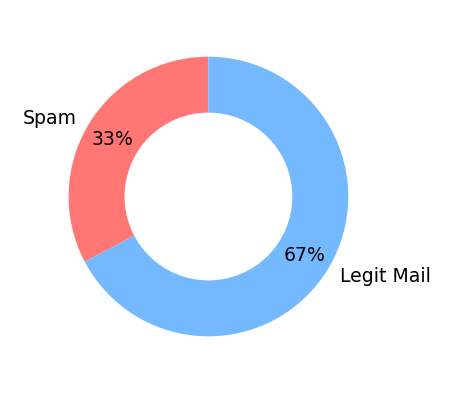

In [33]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ['#ff7675', '#74b9ff']

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
       autopct='%1.0f%%', colors=custom_colours, pctdistance=0.8)

# draw circle
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

# Natural Language Processing

### downloading the resources for nltk

In [ ]:
nltk.download('punkt')

In [ ]:
nltk.download('stopwords')

In [ ]:
nltk.download('gutenberg')
nltk.download('shakespeare')

## Functions for Email Processing

In [ ]:
def clean_message(message, stemmer=PorterStemmer(), 
                 stop_words=set(stopwords.words('english'))):
    
    words = word_tokenize(message.lower())
    
    filtered_words = []
    
    for word in words:
        
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words

In [ ]:
clean_message(email_body)

In [ ]:
# removing html tags
def clean_msg_no_html(message, stemmer=PorterStemmer(), 
                 stop_words=set(stopwords.words('english'))):
    
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    
    words = word_tokenize(cleaned_text.lower())
    
    filtered_words = []
    
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words

In [ ]:
clean_msg_no_html(data.at[2, 'MESSAGE'])

## applying above cleaning to al message in our data 

In [ ]:

nested_list = data.MESSAGE.apply(clean_msg_no_html)

In [67]:
nested_list.tail()

DOC_ID
5791    [one, work, well, week, te, updat, server, syn...
5792    [damien, morton, quot, approv, html, abl, say,...
5793    [mon, che, wrote, that, correct, line, ad, rep...
5794    [upon, time, manfr, wrote, would, like, instal...
5795    [run, pick, use, new, ftoc, button, show, mess...
Name: MESSAGE, dtype: object

### slicing the data frame into category of spam and non spam

In [68]:
data[data.CATEGORY == 1].shape

(1896, 3)

In [69]:
data[data.CATEGORY == 1].tail()

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
1891,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",01311.43bfe86df65d53c5f7ca2365dc12582b
1892,1,<html>\n\n<HEAD> \n\n<TITLE>creditfix</TITLE> ...,00851.dc5452f80ba0bb8481dfc48f70380c4d
1893,1,Hello:\n\n\n\nAre you satisfied with your ISP?...,01328.b23902de23cb3ca1f3334517282372b2
1894,1,<html><HEAD><TITLE>creditfix</TITLE> \n\n</HEA...,01244.9ef966101737a6fc27d8965def288d70
1895,1,<HTML><HEAD></HEAD><BODY><b><FONT SIZE=3D4>In ...,00788.b98a23c07d59156d172683fc29b80661


In [71]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

In [72]:
doc_ids_ham

Int64Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
            ...
            5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
           dtype='int64', name='DOC_ID', length=3900)

### Subsetting a Series with an Index

In [75]:
nested_list_ham = nested_list.loc[doc_ids_ham]

In [76]:
nested_list_ham.shape

(3900,)

In [77]:
nested_list_ham.tail()

DOC_ID
5791    [one, work, well, week, te, updat, server, syn...
5792    [damien, morton, quot, approv, html, abl, say,...
5793    [mon, che, wrote, that, correct, line, ad, rep...
5794    [upon, time, manfr, wrote, would, like, instal...
5795    [run, pick, use, new, ftoc, button, show, mess...
Name: MESSAGE, dtype: object

In [78]:
nested_list_spam = nested_list.loc[doc_ids_spam]

In [80]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()

normal_words.shape[0] # total number of unique words in the non-spam messages

20767

In [81]:
normal_words[:10]

http      7551
use       3623
list      2875
one       2368
get       2283
mail      2255
would     2002
like      1927
messag    1847
work      1795
dtype: int64

In [82]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()

spammy_words.shape[0] # total number of unique words in the spam messages

13295

In [83]:
spammy_words[:10]

http      3099
email     3092
free      2554
click     2056
receiv    1987
list      1970
get       1903
pleas     1840
busi      1792
order     1743
dtype: int64

## using a word cloud to visualize the data of spam and non spam messsages

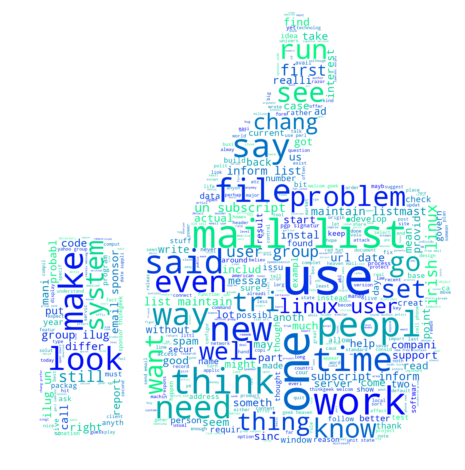

In [95]:
icon = Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

# Generate the text as a string for the word cloud
ham_str = ' '.join(flat_list_ham)

word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                      max_words=500, colormap='winter')

word_cloud.generate(ham_str)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

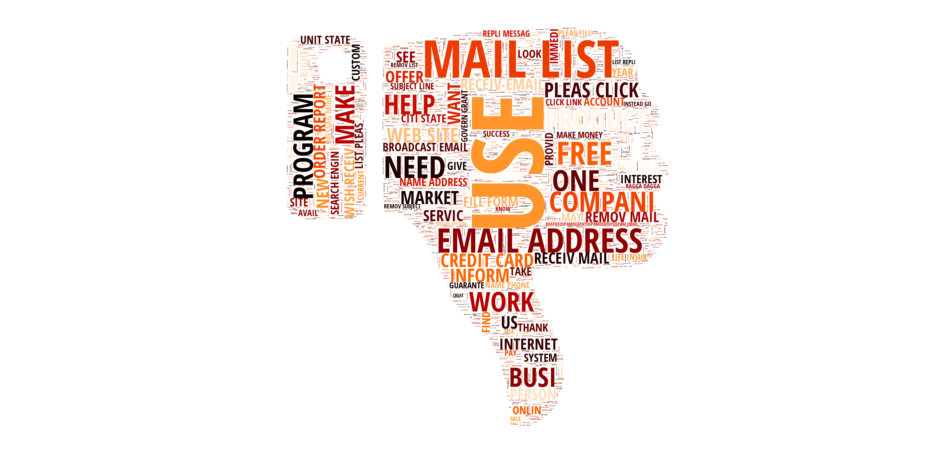

In [97]:
icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

# Generate the text as a string for the word cloud
spam_str = ' '.join(flat_list_spam)

word_cloud = WordCloud(mask=rgb_array, background_color='white', max_font_size=300,
                      max_words=2000, colormap='gist_heat', font_path=CUSTOM_FONT_FILE)

word_cloud.generate(spam_str.upper())

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# generating a dictionary of words in a non spam and spam emails

In [ ]:
stemmed_nested_list = data.MESSAGE.apply(clean_msg_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

In [99]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('Nr of unique words', unique_words.shape[0])
unique_words.head()

Nr of unique words 27320


http     10650
use       5010
list      4845
email     4367
get       4186
dtype: int64

In [102]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


In [103]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

# generating a matrix of words in all emails

In [115]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7651,7652,7653,7654,7655,7656,7657,7658,7659,7660
0,dear,homeown,interest,rate,lowest,point,year,help,find,best,...,None,None,None,None,None,None,None,None,None,None
1,attent,must,comput,user,packag,deal,norton,systemwork,softwar,suit,...,None,None,None,None,None,None,None,None,None,None
2,messag,mime,format,dare,tri,find,better,annuiti,guarante,year,...,None,None,None,None,None,None,None,None,None,None
3,import,inform,new,domain,name,final,avail,gener,public,discount,...,None,None,None,None,None,None,None,None,None,None
4,bottom,line,give,away,cd,free,peopl,like,one,month,...,None,None,None,None,None,None,None,None,None,None


## spliting the data into training set and test set for our model to be trained and tested properly

In [118]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY,
                                                   test_size=0.3, random_state=42)

In [120]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7651,7652,7653,7654,7655,7656,7657,7658,7659,7660
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,thu,jul,rodent,unusu,size,wrote,appli,one,three,order,...,None,None,None,None,None,None,None,None,None,None
4727,well,would,vaniti,list,forward,least,littl,pure,data,week,...,None,None,None,None,None,None,None,None,None,None
5022,world,wide,word,issu,saturday,august,sent,saturday,subscrib,least,...,None,None,None,None,None,None,None,None,None,None
3504,believ,spamassassin,maintain,scheme,wherebi,corpu,distribut,ie,sever,peopl,...,None,None,None,None,None,None,None,None,None,None
3921,sorri,think,send,realiz,list,sender,usual,anyawi,ask,harri,...,None,None,None,None,None,None,None,None,None,None


### Create a Sparse Matrix for the Training Data

In [307]:
word_index = pd.Index(vocab.VOCAB_WORD)
type(word_index[3])

str

In [308]:
word_index.get_loc('thu')

395

In [124]:
  # A dataframe with words in the columns with a document id as an index (X_train or X_test)
    # index of words ordered by word id
    # category as a series (y_train or y_test)
  
def make_sparse_matrix(df, indexed_words, labels):
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            
            word = df.iat[i, j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'LABEL': category, 'DOC_ID': doc_id,
                       'OCCURENCE': 1, 'WORD_ID': word_id}
                
                dict_list.append(item)
    
    return pd.DataFrame(dict_list)

In [ ]:

sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

In [126]:
sparse_train_df[:5]

,DOC_ID,LABEL,OCCURENCE,WORD_ID
0,4844,0,1,395
1,4844,0,1,494
2,4844,0,1,2403
3,4844,0,1,496
4,4844,0,1,37


## beatifying using group by methid

In [ ]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped.head()

In [132]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,0,1,2
1,0,7,1,1
2,0,15,1,1
3,0,18,1,1
4,0,24,1,1


In [133]:
train_grouped.tail()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
265378,5795,1535,0,2
265379,5795,1903,0,1
265380,5795,1905,0,2
265381,5795,2128,0,1
265382,5795,2279,0,1


In [137]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

In [ ]:
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

In [144]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum().reset_index()
test_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,8,7,1,1
1,8,8,1,1
2,8,12,1,1
3,8,19,1,2
4,8,26,1,1


In [312]:
test_grouped.shape

(110307, 4)

In [311]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d')

## removing the redunant emails from our training data

In [313]:
train_doc_ids = set(train_grouped.DOC_ID)
test_doc_ids = set(test_grouped.DOC_ID)

In [316]:
len(test_doc_ids)

1723

In [318]:
len(X_test)

1739

In [321]:
set(X_test.index.values) - test_doc_ids

{14,
 325,
 416,
 445,
 452,
 479,
 576,
 594,
 681,
 856,
 859,
 1001,
 1042,
 1096,
 1109,
 1407}

In [326]:
data.MESSAGE[14] #example of redunant email in our data training set

'------=_NextPart_000_00A3_65E24E1C.A3468E63\n\nContent-Type: text/plain; charset="iso-8859-1"\n\nContent-Transfer-Encoding: base64\n\n\n\n\n\nQ09QWSBEVkQgTU9WSUVTIFRPIENELVINClJJR0hUIE5PVyENCg0KDQpXZSBo\n\nYXZlIEFsbCB0aGUgc29mdHdhcmUgeW91IG5lZWQgdG8gQ09QWSB5b3VyIG93\n\nbiBEVkQgTW92aWVzLg0KDQpDb3B5IHlvdXIgb3duIERWRCBNb3ZpZXMgdXNp\n\nbmcgbm90aGluZyBtb3JlIHRoYW4gb3VyIHNvZnR3YXJlLCBhIA0KRFZELVJP\n\nTSBhbmQgeW91ciBDRC1SIGJ1cm5lciENCg0KQmFja3VwIHlvdXIgRFZEIE1v\n\ndmllIENvbGxlY3Rpb24gDQpQbGF5YmFjayBvbiBhbnkgaG9tZSBEVkQgcGxh\n\neWVyKiANCk5vIEV4cGVuc2l2ZSBEVkQgQnVybmVyIFJlcXVpcmVkIA0KRnJl\n\nZSBMaXZlIFRlY2ggU3VwcG9ydA0KDQogDQpMSU1JVEVEIFRJTUUgT0ZGRVIh\n\nIEZSRUUgRFZEIE1PVklFIE9GIFlPVVIgQ0hPSUNFISBBQ1QgTk9XIQ0KDQoN\n\nCjxhIGhyZWY9Imh0dHA6Ly8yMDIuMTA4LjIyMS4xOC93d3cyODIvcG9zL2R2\n\nZC5odG0iPmNsaWNrIGhlcmU8L2E+DQoNCisrKysrKysrKysrKysrKysrKysr\n\nKysrKysrKysrKysrKysrKysrKysrKysrKysrKysrKysrKysrKysrKysrKysr\n\nKysrKysrKysrKysNClRoaXMgZW1haWwgaGFzIGJlZW4gc2NyZWVuZWQgYW5k\n\nIGZpbHRlcmVkIGJ5IG91ciBpb